# Logistic and linear regression with deterministic and stochastic first order methods

    Lab 3 : Optimisation - DataScience Master
    Authors : Robert Gower, Alexandre Gramfort
   
The aim of this lab is to implement and compare various batch and stochastic algorithms for linear and logistic with ridge penalization. 

The following methods are compared in this notebook.

**Batch (deterministic) methods**

- gradient descent (GD)
- accelerated gradient descent (AGD)
- L-BFGS
- conjugate gradient (CG)

**Stochastic algorithms**

- stochastic gradient descent (SGD)
- stochastic averaged gradient (SAG)
- stochastic variance reduced gradient (SVRG)

Note that we consider as use-cases logistic and linear regression with ridge penalization only, although most of the algorithms below can be used with many other models, and other types of penalization, eventually non-smooth ones, such as the $\ell_1$ penalization.


## VERY IMPORTANT

- This work **must be done by pairs of students**.
- **Each** student must send their work **before the 26th of november at 23:55**, using the **moodle platform**.
- This means that **each student in the pair sends the same file**
- The **name of the file must be** constructed as in the next cell

### How to construct the name of your file

In [6]:
# Change here using YOUR first and last names
fn1 = "xiao"
ln1 = "pan"
fn2 = "yunzhi"
ln2 = "wu"

filename = "_".join(map(lambda s: s.strip().lower(), 
                        ["lab3", ln1, fn1, "and", ln2, fn2])) + ".ipynb"
print(filename)

lab3_pan_xiao_and_wu_yunzhi.ipynb


# Gentle reminder: no evaluation if you don't respect this EXACTLY

### Table of content

[1. Loss functions, gradients and step-sizes](#loss)<br>
[2. Generate a dataset](#data)<br>
[3. Deterministic methods](#batch)<br>
[4. Stochastic methods](#stoc)<br>
[5. Numerical comparison](#comp)<br>
[6. Conclusion](#conc)<br>

In [7]:
%matplotlib inline

In [8]:
import numpy as np
from scipy.linalg import norm
import matplotlib.pyplot as plt

<a id='loss'></a>
## 1. Loss functions, gradients and step-sizes


We want to minimize
$$
\frac 1n \sum_{i=1}^n \ell(a_i^\top x, b_i) + \frac \lambda 2 \|x\|_2^2
$$
where
- $\ell(z, b) = \frac 12 (b - z)^2$ (least-squares regression)
- $\ell(z, b) = \log(1 + \exp(-bz))$ (logistic regression).

We write it as a minimization problem of the form
$$
\frac 1n \sum_{i=1}^n f_i(x)
$$
where
$$
f_i(x) = \ell(a_i^\top x, b_i) + \frac \lambda 2 \|x\|_2^2.
$$

For both cases, the gradients are
$$
\nabla f_i(x) = (a_i^\top x - b_i) a_i + \lambda x
$$
and
$$
\nabla f_i(x) = - \frac{b_i}{1 + \exp(b_i a_i^\top x)} a_i + \lambda x.
$$

Denote by $L$ (resp. $L_i$) the Lipschitz constant of $f$ (resp. $f_i$) and $\mathbf A^\top = [a_1, \ldots, a_n].$
One can easily see (using $\|\cdot\|_{2}$ for the matrix spectrale norm) that for linear regression
$$
L = \frac{ \|\mathbf A^\top \mathbf A \|_{2}}{n} + \lambda \quad \text{ and } L_i = \| a_i \|_2^2 + \lambda
$$
while for logistic regression it is
$$
L = \frac{ \|\mathbf A^\top \mathbf A \|_{2}}{4 n} + \lambda \quad \text{ and } L_i = \frac 14 \| a_i \|_2^2 + \lambda.
$$
For full-gradient methods, the theoretical step-size is $1 / L$, while for SAG and SVRG (see below) it can be taken as
$1 / (\max_{i=1,\ldots,n} L_i)$

We now introduce a class that will be used for the solvers.

In [9]:
from scipy.linalg import svd


class LinReg(object):
    """A class for the least-squares regression with L2/Ridge penalization"""

    def __init__(self, A, b, lbda):
        self.A = A
        self.b = b
        self.n, self.d = A.shape
        self.lbda = lbda

    def grad(self, x):
        return self.A.T.dot(self.A.dot(x) - self.b) / self.n + self.lbda * x

    def loss(self, x):
        return norm(self.A.dot(x) - self.b) ** 2 / (2. * self.n) + self.lbda * norm(x) ** 2 / 2.

    def grad_i(self, i, x):
        a_i = self.A[i]
        return (a_i.dot(x) - self.b[i]) * a_i + self.lbda * x

    def lipschitz_constant(self):
        """Return the Lipschitz constant of the gradient"""
        return norm(self.A, ord=2) ** 2 / self.n + self.lbda

In [10]:
class LogReg(object):
    """A class for the logistic regression with L2/Ridge penalization"""

    def __init__(self, A, b, lbda):
        self.A = A
        self.b = b
        self.n, self.d = A.shape
        self.lbda = lbda
    
    def grad(self, x):
        bAx = self.b * np.dot(self.A, x)
        temp = 1. / (1. + np.exp(bAx))
        grad = - np.dot(self.A.T, self.b * temp) / self.n + self.lbda * x
        return grad

    def loss(self, x):
        bAx = self.b * np.dot(self.A, x)
        return np.mean(np.log(1. + np.exp(- bAx))) + self.lbda * norm(x) ** 2 / 2.
    
    def grad_i(self, i, x):
        grad = - self.A[i] * self.b[i] / (1. + np.exp(self.b[i] * np.dot(self.A[i], x)))
        grad += self.lbda * x
        return grad

    def lipschitz_constant(self):
        """Return the Lipschitz constant of the gradient"""
        return norm(self.A, ord=2) ** 2 / (4. * self.n) + self.lbda

<a id='data'></a>
## 2. Generate a dataset

We generate datasets for the least-squares and the logistic cases. First we define a function for the least-squares case.

In [11]:
from numpy.random import multivariate_normal, randn
from scipy.linalg.special_matrices import toeplitz


def simu_linreg(x, n, std=1., corr=0.5):
    """
    Simulation for the least-squares problem

    Parameters
    ----------
    x : ndarray, shape (d,)
        The coefficients of the model
    n : int
        Sample size
    std : float, default=1.
        Standard-deviation of the noise
    corr : float, default=0.5
        Correlation of the features matrix
    
    Returns
    -------
    A : ndarray, shape (n, d)
        The design matrix.
    b : ndarray, shape (n,)
        The targets.
    """
    d = x.shape[0]
    cov = toeplitz(corr ** np.arange(0, d))
    A = multivariate_normal(np.zeros(d), cov, size=n)
    noise = std * randn(n)
    b = A.dot(x) + noise
    return A, b

In [12]:
def simu_logreg(x, n, std=1., corr=0.5):
    """
    Simulation for the logistic regression problem
    
    Parameters
    ----------
    x : ndarray, shape (d,)
        The coefficients of the model
    n : int
        Sample size    
    std : float, default=1.
        Standard-deviation of the noise
    corr : float, default=0.5
        Correlation of the features matrix
    
    Returns
    -------
    A : ndarray, shape (n, d)
        The design matrix.
    b : ndarray, shape (n,)
        The targets.
    """    
    A, b = simu_linreg(x, n, std=1., corr=0.5)
    return A, np.sign(b)

In [13]:
d = 50
n = 10000
idx = np.arange(d)

# Ground truth coefficients of the model
x_model_truth = (-1)**idx * np.exp(-idx / 10.)

_A, _b = simu_logreg(x_model_truth, n, std=1., corr=0.1)
#_A, _b = simu_linreg(x_model_truth, n, std=1., corr=0.7)

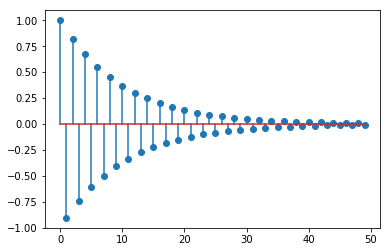

In [14]:
plt.stem(x_model_truth);

### Numerically check loss and gradient

In [15]:
from scipy.optimize import check_grad

lbda = 1. / n ** (0.5)
model = LinReg(_A, _b, lbda)

# Check that the gradient and the loss numerically match
check_grad(model.loss, model.grad, np.random.randn(d))

1.8577572126612221e-06

In [16]:
lbda = 1. / n ** (0.5)
model = LogReg(_A, _b, lbda)

# Check that the gradient and the loss numerically match
check_grad(model.loss, model.grad, np.random.randn(d))

1.3571405500828828e-07

### Choice of the model

In [17]:
# model = LinReg(_A, _b, lbda)
model = LogReg(_A, _b, lbda)

### Compute the theoretical step-size for FISTA

In [18]:
from scipy.linalg import svd

step = 1. / model.lipschitz_constant()

print("step = %s" % step)

step = 1.31316468719


### Get a very precise minimum to compute distances to minimum

In [19]:
from scipy.optimize import fmin_l_bfgs_b
x_init = np.zeros(d)
x_min, f_min, _ = fmin_l_bfgs_b(model.loss, x_init, model.grad, pgtol=1e-30, factr=1e-30)
print(f_min)

0.455106344309


<a id='batch'></a> 

## 3. Deterministic methods (ISTA, FISTA, BFGS)

Before implementing GD, ISTA or FISTA we provide a simple function to be called after each iteration to gather and display a few metrics about the current minimization process.

In [20]:
import time

def inspector(loss_fun, x_real, verbose=False):
    """A closure called to update metrics after each iteration."""
    objectives = []
    errors = []
    t0 = time.time()
    it = [0] # This is a hack to be able to modify 'it' inside the closure.
    timing = [] 
    def inspector_cl(xk):
        obj = loss_fun(xk) - f_min
        err = norm(xk - x_min)
        tim = time.time()-t0
        objectives.append(obj)
        errors.append(err)
        timing.append(tim)
        if verbose == True:
            if it[0] == 0:
                print(' | '.join([name.center(8) for name in ["it", "obj", "err", "time"]]))
            if it[0] % (n_iter / 5) == 0:
                print(' | '.join([("%d" % it[0]).rjust(8), ("%.2e" % obj).rjust(8), ("%.2e" % err).rjust(8), ("%.4e" % tim).rjust(8)]))
            it[0] += 1
    inspector_cl.obj = objectives
    inspector_cl.err = errors
    inspector_cl.timing = timing

    return inspector_cl

In [21]:
# Number of iterations
n_iter = 50

### ISTA

We recall that an iteration of ISTA (actually a batch gradient here) writes

$$
x_{k+1} \gets x_k - \eta \nabla f(x_k)
$$

where $\eta$ is the step-size (that can be chosen in theory as $\eta = 1 / L$, with $L$ the Lipshitz constant of $\nabla f$, see above)

*QUESTION*:
- Fill in the iteration of the ISTA solver in the cell below

In [22]:
def ista(x_init, grad, n_iter=100, step=1., callback=None):
    """ISTA algorithm."""
    x = x_init.copy()
    
    for _ in range(n_iter):
        
        ### TODO
        x = x - step * grad(x)
        
        ### END TODO

        # Update metrics after each iteration.
        if callback is not None: 
            callback(x)

    return x

In [23]:
step = 1. / model.lipschitz_constant()
x_init = np.zeros(d)
ista_inspector = inspector(model.loss, x_min, verbose=True)
x_ista = ista(x_init, model.grad, n_iter, step, callback=ista_inspector)

   it    |   obj    |   err    |   time  
       0 | 1.80e-01 | 2.52e+00 | 0.0000e+00
      10 | 3.03e-02 | 1.16e+00 | 3.1000e-02
      20 | 8.08e-03 | 6.24e-01 | 5.2000e-02
      30 | 2.50e-03 | 3.54e-01 | 6.9000e-02
      40 | 8.25e-04 | 2.05e-01 | 8.5000e-02


### FISTA

We recall that an iteration of FISTA (actually an accelerated batch gradient here) writes

$$
\begin{align*}
x_{k+1} &\gets y_k - \eta \nabla f(y_k) \\
t_{k+1} &\gets \frac{1 + \sqrt{1 + 4 t_k^2}}{2} \\
y_{k+1} &\gets x_{k+1} + \frac{t_k-1}{t_{k+1}} (x_{k+1} - x_k)
\end{align*}
$$

where $\eta$ is the step-size (that can be chosen in theory as $\eta = 1 / L$, with $L$ the Lipshitz constant of $\nabla f$, see above)

*QUESTION*:
- Fill in the iteration of the FISTA solver in the cell below

In [24]:
def fista(x_init, grad, n_iter=100, step=1., callback=None):
    """FISTA algorithm."""
    x = x_init.copy()
    y = x_init.copy()
    t = 1.
    z = x_init.copy()
    
    for _ in range(n_iter):
        
        ### TODO
        x_new = z - step * grad(z)
        t_new = (1. + np.sqrt(1. + 4 * t ** 2)) / 2.
        z = x_new + (t - 1.) / t_new * (x_new - x)      
        x = x_new
        t = t_new
        ### END TODO

        # Update metrics after each iteration.
        if callback is not None: 
            callback(x)
    return x

In [25]:
step = 1. / model.lipschitz_constant()
x_init = np.zeros(d)
fista_inspector = inspector(model.loss, x_min, verbose=True)
x_fista = fista(x_init, model.grad, n_iter, step, callback=fista_inspector)

   it    |   obj    |   err    |   time  
       0 | 1.80e-01 | 2.52e+00 | 3.0000e-03
      10 | 2.22e-03 | 3.33e-01 | 2.6000e-02
      20 | 5.41e-04 | 1.70e-01 | 4.6000e-02
      30 | 3.27e-05 | 4.13e-02 | 6.4000e-02
      40 | 2.56e-06 | 1.16e-02 | 8.6000e-02


### scipy.optimize's conjuguate gradient

Let's compare with ``scipy.optimize``'s conjuguate gradient solver.

In [26]:
# Conjugate gradient descent
from scipy.optimize import fmin_cg

x_init = np.zeros(d)
cg_inspector = inspector(model.loss, x_min, verbose=True)
x_cg = fmin_cg(model.loss, x_init, model.grad, maxiter=n_iter, callback=cg_inspector)

   it    |   obj    |   err    |   time  
       0 | 9.66e-02 | 1.81e+00 | 1.6000e-02
      10 | 4.35e-07 | 3.89e-03 | 6.9000e-02
Optimization terminated successfully.
         Current function value: 0.455106
         Iterations: 16
         Function evaluations: 33
         Gradient evaluations: 33


### scipy.optimize's BFGS

Let's compare with ``scipy.optimize``'s BFGS solver

In [27]:
# Conjugate gradient descent
from scipy.optimize import fmin_l_bfgs_b

x_init = np.zeros(d)
bfgs_inspector = inspector(model.loss, x_min, verbose=True)
x_bfgs, _, _ = fmin_l_bfgs_b(model.loss, x_init, model.grad, maxiter=n_iter, callback=bfgs_inspector)

   it    |   obj    |   err    |   time  
       0 | 1.03e-01 | 1.91e+00 | 3.9999e-03
      10 | 7.60e-08 | 1.04e-03 | 5.1000e-02


### A first numerical comparison of deterministic solvers

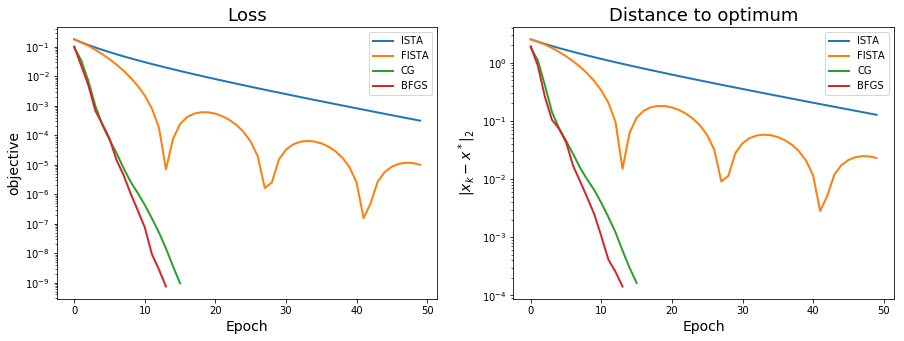

In [28]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)

inspectors = [ista_inspector, fista_inspector, cg_inspector, bfgs_inspector]

solvers = ["ISTA", "FISTA", "CG", "BFGS"]

for insp in inspectors:
    plt.semilogy(insp.obj, lw=2)
    plt.title("Loss", fontsize=18)
    plt.xlabel("Epoch", fontsize=14)
    plt.ylabel("objective", fontsize=14)

plt.legend(solvers)

plt.subplot(1, 2, 2)

for insp in inspectors:
    plt.semilogy(insp.err, lw=2)
    plt.title("Distance to optimum", fontsize=18)
    plt.xlabel("Epoch", fontsize=14)
    plt.ylabel("$\|x_k - x^*\|_2$", fontsize=14)

plt.legend(solvers);

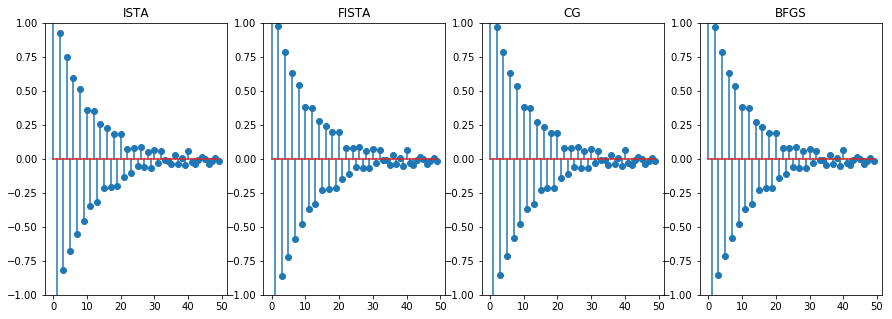

In [29]:
plt.figure(figsize=(15, 5))

xs = [x_ista, x_fista, x_cg, x_bfgs]

for i, name, x in zip(range(1, 5), solvers, xs):
    plt.subplot(1, 4, i)
    plt.stem(x)
    plt.ylim([-1, 1])
    plt.title(name)

### First conclusions

*QUESTIONS*:

- Give some first conclusions about the batch solver studied here
- What do you observe about FISTA? is it suprising ?

*ANSWERS*:

- CG and BFGS converges much faster than ISTA and FISTA for both linear regression and logistics regression.
- For logistic regression FISTA is obviously better than ISTA.
- FISTA 
    The objective function's value and distance to the optimum vibrates.
    In the FISTA (in the case above we don't consider proxiaml), the iterative shrinkage     operator(gradient descent) is not apllied on $x_k$, but on $y_k$, a specific linear    combination of the two previous points $x_{k-1}, x_{k}$. FISTA doesn't ensure that the objective value decreases at each iteration. In each iteration the change of x is affected by the previous steps, but the more close step has greater impact, and the impact of far steps gradually disappear. That's why we observe a periodically change. 

<a id='stoc'></a> 
## 4. Stochastic methods

In [30]:
n_iter = 50

# generate indices of random samples
iis = np.random.randint(0, n, n * n_iter)  

### SGD

We recall that an iteration of SGD writes

- Pick $i$ uniformly at random in $\{1, \ldots, n\}$
- Apply
$$
x_{t+1} \gets x_t - \frac{\eta_0}{\sqrt{t+1}} \nabla f_i(x_t)
$$

where $\eta_0$ is a step-size to be tuned by hand.

*QUESTION*:
- Fill in the iteration of the SGD solver in the cell below

In [31]:
def sgd(x_init, iis, grad_i, n_iter=100, step=1., callback=None):
    """Stochastic gradient descent algorithm."""
    x = x_init.copy()
    
    for idx in range(n_iter):
        i = iis[idx]
        
        ### TODO
        x = x - step / np.sqrt(idx + 1) * model.grad_i(i, x)

        ### END TODO
        
        # Update metrics after each iteration.
        if callback is not None and idx % n == 0:
            callback(x)
    return x

In [32]:
step0 = 1.
x_init = np.zeros(d)
sgd_inspector = inspector(model.loss, x_min, verbose=True)
x_sgd = sgd(x_init, iis, model.grad_i, n * n_iter, step=step0, callback=sgd_inspector)

   it    |   obj    |   err    |   time  
       0 | 1.23e+00 | 4.09e+00 | 1.5000e-02
      10 | 6.74e-03 | 2.52e-01 | 1.7200e+00
      20 | 4.92e-03 | 2.11e-01 | 3.1240e+00
      30 | 3.89e-03 | 1.77e-01 | 4.4030e+00
      40 | 3.24e-03 | 1.89e-01 | 5.6620e+00


### SAG

We recall that an iteration of SAG writes

For $t=1, \ldots, $ until convergence

1. Pick $i_t$ uniformly at random in $\{1, \ldots, n\}$

2. Update the average of gradients
$$
G_t \gets \frac 1n \sum_{i=1}^n g_i^t
$$
where 
$$
g_i^t =
\begin{cases}
    \nabla f_{i}(x_t) &\text{ if } i = i_t \\
    g_i^{t-1} & \text{ otherwise.}
\end{cases}
$$

3. Apply the step 
$$x_{t+1} \gets x_t - \eta G_t$$
where $\eta$ is the step-size (see code below).

*QUESTION*:
- Fill in the iteration of the SAG solver in the cell below

In [33]:
def sag(x_init, iis, grad_i, n_iter=100, step=1., callback=None):
    """Stochastic average gradient algorithm."""
    x = x_init.copy()
    # Old gradients
    gradient_memory = np.zeros((n, d))
    y = np.zeros(d)
    x_average = np.zeros(x.shape[0])
    det = 0
    for idx in range(n_iter):
        i = iis[idx]
        
        ### TODO
        y = model.grad_i(i,x)
        det = det - gradient_memory[i] + y
        x = x - step * det / n
        gradient_memory[i] = y
        ### END OF TODO
        
        # Update metrics after each iteration.
        if callback is not None and idx % n == 0:
            callback(x)
    return x

In [34]:
max_squared_sum = np.max(np.sum(model.A ** 2, axis=1))

if isinstance(model, LogReg):
    step = 4.0 / (max_squared_sum + 4.0 * model.lbda)
else:
    step = 1.0 / (max_squared_sum + model.lbda)

x_init = np.zeros(d)
sag_inspector = inspector(model.loss, x_min, verbose=True)
x_sag = sag(x_init, iis, model.grad_i, n * n_iter, step, callback=sag_inspector)

   it    |   obj    |   err    |   time  
       0 | 2.38e-01 | 2.79e+00 | 1.1000e-02
      10 | 1.22e-03 | 1.13e-01 | 1.6310e+00
      20 | 6.67e-06 | 8.10e-03 | 3.2690e+00
      30 | 2.53e-08 | 5.59e-04 | 4.9040e+00
      40 | 1.06e-10 | 3.99e-05 | 6.4850e+00


### SVRG

We recall that an iteration of SVRG writes

For $k=1, \ldots, $ until convergence

1. Set $\tilde x \gets \tilde x^{(k)}$ and $x_1^{(k)} \gets \tilde x$
2. Compute $\mu_k \gets \nabla f(\tilde x)$
3. For $t=1, \ldots, n$
    4. Pick $i$ uniformly at random in $\{1, \ldots, n\}$
    5. Apply the step 
$$
x_{t+1}^{(k)} \gets x_t^{(k)} - \eta \big(\nabla f_{i}(x_t^{(k)}) - \nabla f_{i}(\tilde x) + \mu_k \big) 
$$

6. Set $\tilde x^{(k+1)} \gets x_{n+1}^{(k)}$

where $\eta$ is the step-size (see code below).

*QUESTION*:
- Fill in the iteration of the SVRG solver in the cell below

In [35]:
def svrg(x_init, iis, grad, grad_i, n_iter, step, callback=None):
    """Stochastic variance reduction gradient algorithm."""
    x = x_init.copy()
    x_old = x.copy()
    
    for idx in range(int(n_iter/n)):
        x_ = x.copy()
        grad_ = grad(x_)
        ### TODO
        for k in range(n):
            j = np.random.randint(n)
            g = grad_i(j, x) - grad_i(j, x_) + grad_
            x = x - step * g
            
        ### END TODO        
    
#         if callback is not None and idx % n == 0:
        callback(x)
    return x

In [36]:
if isinstance(model, LogReg):
    step = 4.0 / (max_squared_sum + 4.0 * model.lbda)
else:
    step = 1.0 / (max_squared_sum + model.lbda)

x_init = np.zeros(d)
svrg_inspector = inspector(model.loss, x_min, verbose=True)    
x_svrg = svrg(x_init, iis, model.grad, model.grad_i, n_iter*n, step, callback=svrg_inspector)

   it    |   obj    |   err    |   time  
       0 | 3.84e-02 | 6.62e-01 | 3.5400e-01
      10 | 1.62e-09 | 1.49e-04 | 3.1790e+00
      20 | 0.00e+00 | 3.05e-08 | 6.0010e+00
      30 | -5.55e-17 | 1.57e-08 | 8.5120e+00
      40 | -5.55e-17 | 1.57e-08 | 1.0898e+01


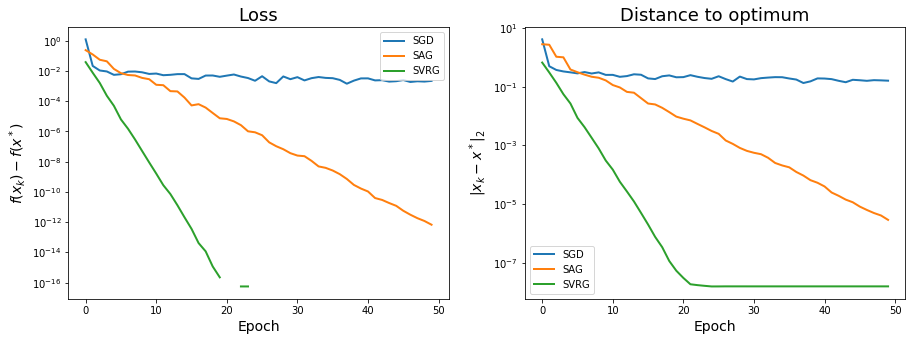

In [37]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)

inspectors = [sgd_inspector, sag_inspector, svrg_inspector]

solvers = ["SGD", "SAG", "SVRG"]

for insp in inspectors:
    plt.semilogy(insp.obj, lw=2)
    plt.title("Loss", fontsize=18)
    plt.xlabel("Epoch", fontsize=14)
    plt.ylabel("$f(x_k) - f(x^*)$", fontsize=14)

plt.legend(solvers)

plt.subplot(1, 2, 2)

for insp in inspectors:
    plt.semilogy(insp.err, lw=2)
    plt.title("Distance to optimum", fontsize=18)
    plt.xlabel("Epoch", fontsize=14)
    plt.ylabel("$\|x_k - x^*\|_2$", fontsize=14)

plt.legend(solvers);

<a id='comp'></a> 
## 5. Numerical comparison

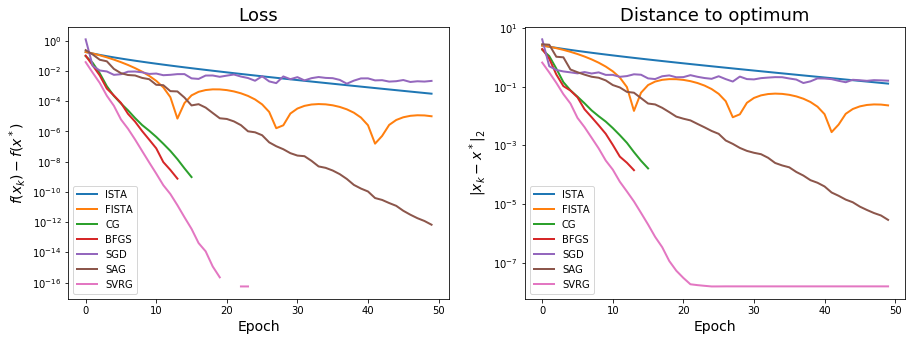

In [38]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)

inspectors = [ista_inspector, fista_inspector, cg_inspector, bfgs_inspector,
              sgd_inspector, sag_inspector, svrg_inspector]

solvers = ["ISTA", "FISTA", "CG", "BFGS", "SGD", "SAG", "SVRG"]

for insp in inspectors:
    plt.semilogy(insp.obj, lw=2)
    plt.title("Loss", fontsize=18)
    plt.xlabel("Epoch", fontsize=14)
    plt.ylabel("$f(x_k) - f(x^*)$", fontsize=14)

plt.legend(solvers)

plt.subplot(1, 2, 2)

for insp in inspectors:
    plt.semilogy(insp.err, lw=2)
    plt.title("Distance to optimum", fontsize=18)
    plt.xlabel("Epoch", fontsize=14)
    plt.ylabel("$\|x_k - x^*\|_2$", fontsize=14)

plt.legend(solvers);

<a id='conc'></a>
## 6. Conclusion

*QUESTIONS*:
- Compare and comment your results
- Change the value of the ridge regularization (the ``lbda`` parameter) to low ridge $\lambda = 1 / n$ and high ridge regularization $\lambda = 1 / \sqrt n$ and compare your results. Comment.
- Play also with the level of correlation between features (parameter ``corr`` above), and compare results with low and high correlation.
- Conclude

## *ANSWERS*:

### 1. Compare and comment the results.

* SGD is faster than SVG and SVRG at the beginning and then slower down. That's because the step in SGD is $\frac{\eta_0}{\sqrt{t+1}}$ and decreases with iteration while the steps of SAG and SVRG are constant. In general, SGD performes worst.

* SVRG performes better because while SAG conserves information of all the previous steps, it conserves only the most n close steps' information. Thus, in SVRG each iteration will not be mcuh too affected by the information which have little relevant.

* CG and BFGS performs better than other algorithms because they use linear search in each step.

* CG only conserves the direction information of all the previous steps(conjugate to the previous space), so it avoids over-adjustment compared to FISTA.

* BFGS reinitialzes the direction periodically, thus the information too early doesn't have impact.<br\>


### An auxilliary function for displaying the results

In [44]:
def func(n_iter, ver):
    # compute the step size for ISTA and FISTA
    step = 1. / model.lipschitz_constant()
    
    # ISTA
    ista_inspector = inspector(model.loss, x_min, verbose=ver)
    x_ista = ista(x_init, model.grad, n_iter, step, callback=ista_inspector)
    
    # FISTA
    #x_init = np.zeros(d)
    fista_inspector = inspector(model.loss, x_min, verbose=ver)
    x_fista = fista(x_init, model.grad, n_iter, step, callback=fista_inspector)
    
    # CG
    #x_init = np.zeros(d)
    cg_inspector = inspector(model.loss, x_min, verbose=ver)
    x_cg = fmin_cg(model.loss, x_init, model.grad, maxiter=n_iter, callback=cg_inspector, disp=ver)
    
    # BFGS
    #x_init = np.zeros(d)
    bfgs_inspector = inspector(model.loss, x_min, verbose=ver)
    x_bfgs, _, _ = fmin_l_bfgs_b(model.loss, x_init, model.grad, maxiter=n_iter, callback=bfgs_inspector)
    
    iis = np.random.randint(0, n, n * n_iter)
    
    # SGD
    step0 = 1.
    #x_init = np.zeros(d)
    sgd_inspector = inspector(model.loss, x_min, verbose=ver)
    x_sgd = sgd(x_init, iis, model.grad_i, n * n_iter, step=step0, callback=sgd_inspector)
    
    # compute the step size for SAG and SVRG
    max_squared_sum = np.max(np.sum(model.A ** 2, axis=1))
    if isinstance(model, LogReg):
        step = 4.0 / (max_squared_sum + 4.0 * model.lbda)
    else:
        step = 1.0 / (max_squared_sum + model.lbda)
        
    # SAG
    sag_inspector = inspector(model.loss, x_min, verbose=ver)
    x_sag = sag(x_init, iis, model.grad_i, n * n_iter, step, callback=sag_inspector)

    # SVRG
    #x_init = np.zeros(d)
    svrg_inspector = inspector(model.loss, x_min, verbose=ver)    
    x_svrg = svrg(x_init, iis, model.grad, model.grad_i, n_iter*n, step, callback=svrg_inspector)
    
    plt.figure(figsize=(15, 5))
    plt.suptitle(s + ", corr=" + str(corr)+ ", lambda=" + str(lbda))

    plt.subplot(1, 2, 1)
    
    inspectors = [ista_inspector, fista_inspector, cg_inspector, bfgs_inspector,
                  sgd_inspector, sag_inspector, svrg_inspector]

    solvers = ["ISTA", "FISTA", "CG", "BFGS", "SGD", "SAG", "SVRG"]

    for insp in inspectors:
        plt.semilogy(insp.obj, lw=2)
        plt.title("Loss", fontsize=18)
        plt.xlabel("Epoch", fontsize=14)
        plt.ylabel("$f(x_k) - f(x^*)$", fontsize=14)
    plt.legend(solvers)

    plt.subplot(1, 2, 2)

    for insp in inspectors:
        plt.semilogy(insp.err, lw=2)
        plt.title("Distance to optimum", fontsize=18)
        plt.xlabel("Epoch", fontsize=14)
        plt.ylabel("$\|x_k - x^*\|_2$", fontsize=14)
    plt.legend(solvers)

### 2. Change the value of the ridge regularization


Linear Regression, corr = 0.1, lambda = 1/n^(0.5)
0.528463361926
Linear Regression, corr = 0.1, lambda = 1/n
0.501083092168


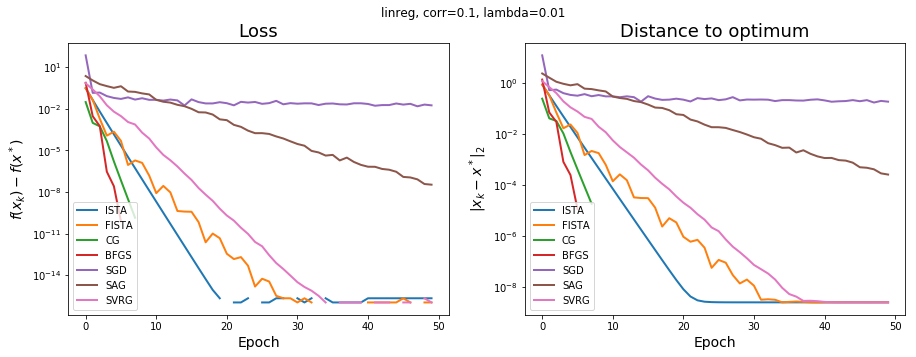

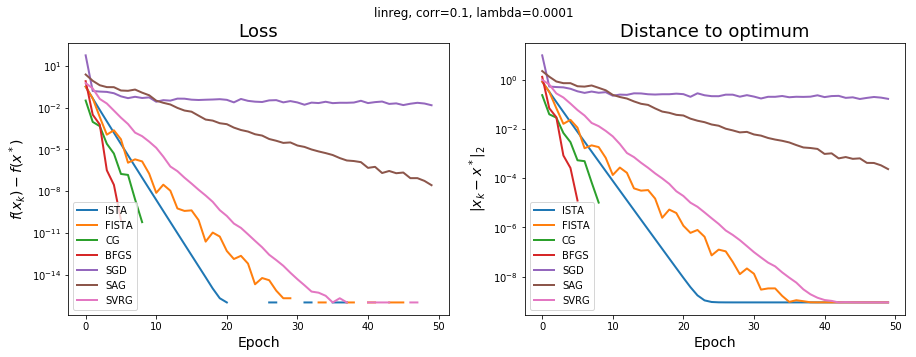

In [45]:

n_iter = 50
corr = 0.1
_A, _b = simu_linreg(x_model_truth, n, std=1., corr=corr)
s = 'linreg'
## lambda = 1/n^0.5
lbda = 1. / n ** (0.5)
model = LinReg(_A, _b, lbda)
print ("Linear Regression, corr = 0.1, lambda = 1/n^(0.5)")

# compute the precise minimum
x_init = np.zeros(d)
x_min, f_min, _ = fmin_l_bfgs_b(model.loss, x_init, model.grad, pgtol=1e-30, factr=1e-30)
print(f_min)
func(n_iter, False)

## lambda = 1/n
lbda = 1. / n
model = LinReg(_A, _b, lbda)
print ("Linear Regression, corr = 0.1, lambda = 1/n")

# compute the precise minimum
x_init = np.zeros(d)
x_min, f_min, _ = fmin_l_bfgs_b(model.loss, x_init, model.grad, pgtol=1e-30, factr=1e-30)
print(f_min)
func(n_iter, False)

Logistic Regression, corr = 0.1, lambda = 1/n^(0.5)
0.46194956173
Logistic Regression, corr = 0.1, lambda = 1/n
0.410421936309


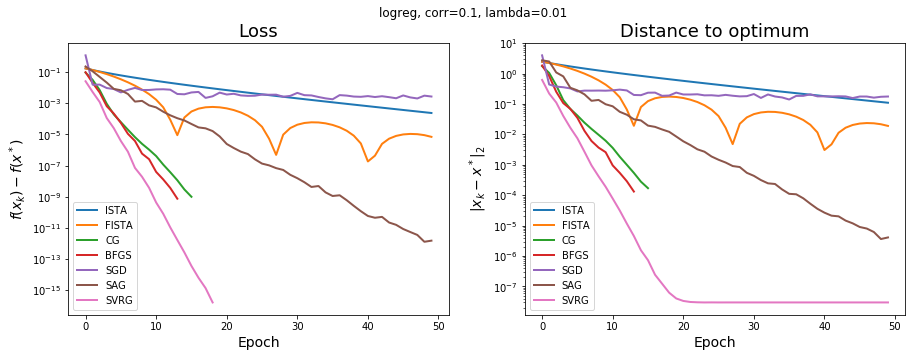

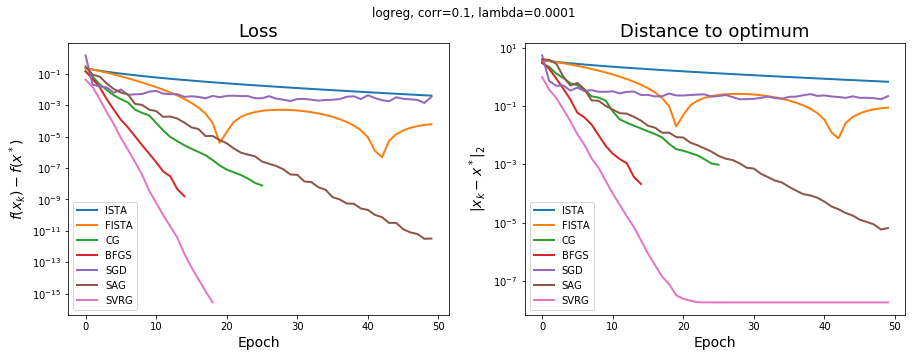

In [46]:
n_iter = 50
corr = 0.1
_A, _b = simu_logreg(x_model_truth, n, std=1., corr=corr)
s = 'logreg'
## lambda = 1/n^0.5
lbda = 1. / n ** (0.5)
model = LogReg(_A, _b, lbda)
print ("Logistic Regression, corr = 0.1, lambda = 1/n^(0.5)")

# compute the precise minimum
x_init = np.zeros(d)
x_min, f_min, _ = fmin_l_bfgs_b(model.loss, x_init, model.grad, pgtol=1e-30, factr=1e-30)
print(f_min)
func(n_iter, False)

## lambda = 1/n
lbda = 1. / n
model = LogReg(_A, _b, lbda)
print ("Logistic Regression, corr = 0.1, lambda = 1/n")

# compute the precise minimum
x_init = np.zeros(d)
x_min, f_min, _ = fmin_l_bfgs_b(model.loss, x_init, model.grad, pgtol=1e-30, factr=1e-30)
print(f_min)

func(n_iter, False)

#### Obeservations and Comments
when $\lambda$ is smaller:

In linear regression: 
- The convergence of algorithms doesn't have remarkable change except for the small change of final result according to the change fo the objective function.

In logistic regression:
- CG, FISTA, and ISTA converges slower.
- The FISTA vibrates less frequently.


### 3. Change the level of correlation between features

Linear Regression, corr = 0.1, lambda = 1/n^(0.5)
0.523303290078
Linear Regression, corr = 0.3, lambda = 1/n^(0.5)
0.522514183341


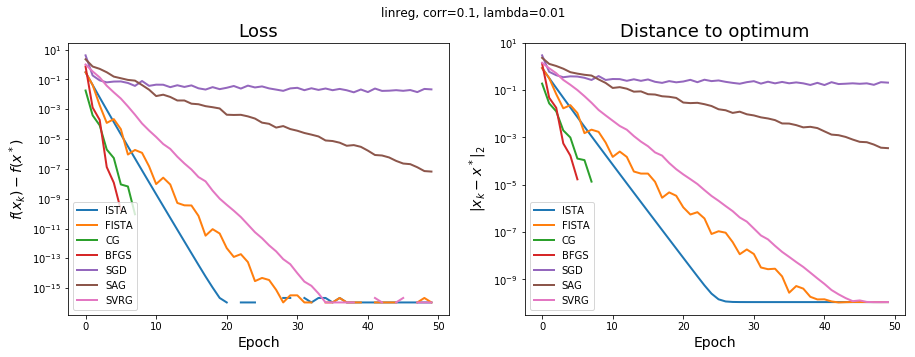

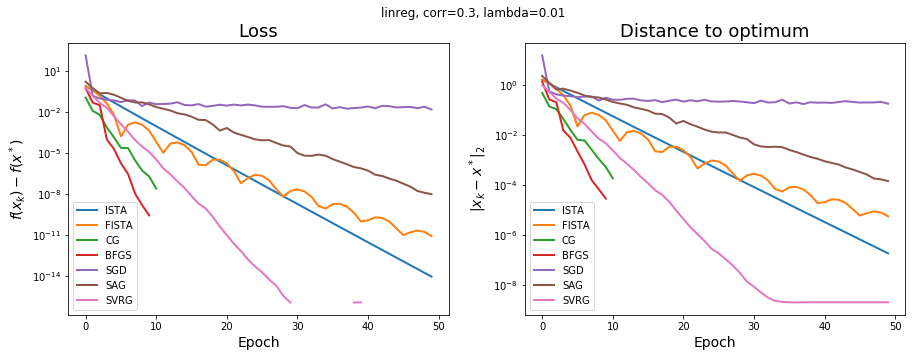

In [47]:
n_iter = 50
lbda = 1. / n ** (0.5)
corr = 0.1
s = 'linreg'

## correlation = 0.1
_A, _b = simu_linreg(x_model_truth, n, std=1., corr=corr)
model = LinReg(_A, _b, lbda)
print ("Linear Regression, corr = 0.1, lambda = 1/n^(0.5)")

# compute the precise minimum
x_init = np.zeros(d)
x_min, f_min, _ = fmin_l_bfgs_b(model.loss, x_init, model.grad, pgtol=1e-30, factr=1e-30)
print(f_min)

func(n_iter, False)

## correlation = 0.1
corr = 0.3
_A, _b = simu_linreg(x_model_truth, n, std=1., corr=corr)
model = LinReg(_A, _b, lbda)
print ("Linear Regression, corr = 0.3, lambda = 1/n^(0.5)")

# compute the precise minimum
x_init = np.zeros(d)
x_min, f_min, _ = fmin_l_bfgs_b(model.loss, x_init, model.grad, pgtol=1e-30, factr=1e-30)
print(f_min)

func(n_iter, False)

Logistic Regression, corr = 0.1, lambda = 1/n^(0.5)
0.455140595386
Logistic Regression, corr = 0.3, lambda = 1/n^(0.5)
0.45668859593


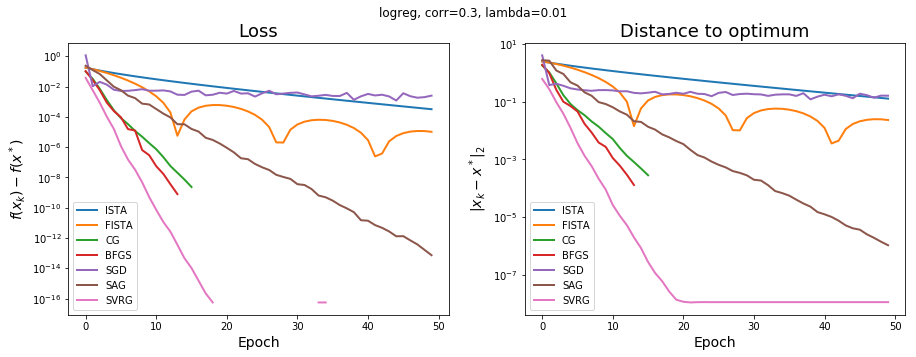

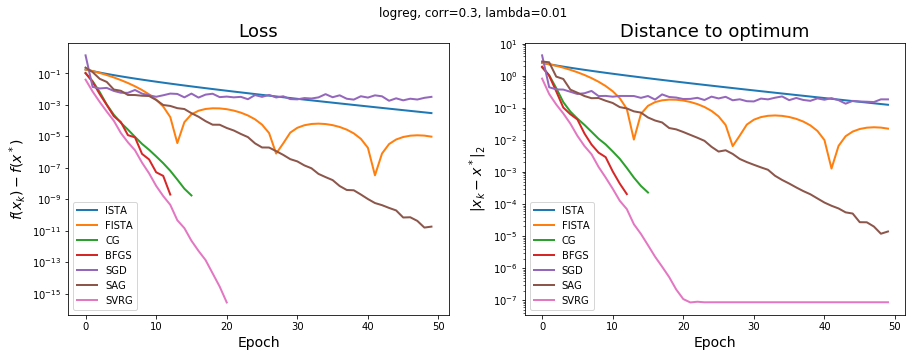

In [48]:
n_iter = 50
lbda = 1. / n ** (0.5)
s = "logreg"


## correlation = 0.1
_A, _b = simu_logreg(x_model_truth, n, std=1., corr=0.1)
model = LogReg(_A, _b, lbda)
print ("Logistic Regression, corr = 0.1, lambda = 1/n^(0.5)")

# compute the precise minimum
x_init = np.zeros(d)
x_min, f_min, _ = fmin_l_bfgs_b(model.loss, x_init, model.grad, pgtol=1e-30, factr=1e-30)
print(f_min)

func(n_iter, False)

## correlation = 0.1
_A, _b = simu_logreg(x_model_truth, n, std=1., corr=0.3)
model = LogReg(_A, _b, lbda)
print ("Logistic Regression, corr = 0.3, lambda = 1/n^(0.5)")

# compute the precise minimum
x_init = np.zeros(d)
x_min, f_min, _ = fmin_l_bfgs_b(model.loss, x_init, model.grad, pgtol=1e-30, factr=1e-30)
print(f_min)

func(n_iter, False)

#### Obeservations and Comments
When increassing correlation,

In linear regression:

- ISTA and FISTA remarkably converges slower. These two algorithms are most direct, which uses gradient descent or have modification in direction. The features are more relevant and the linear model is not precise enough to describe it. On the other hand, the other algorithms are more sophisticated and correlation doesn't have remarkable impact on them.
- SAG converges faster.
- CG converges slower.
In logistic regression:
- The performance of each algorithm doesn't change much, even for FISTA and ISTA. Because the correlation of features is already considered in logistic model.
- SAG converges faster.
- CG converges slower.

### 4. Conclusion

- Linear Regression is less sensitive to the change of $\lambda$ than Logistic Regression.

- Logistic Regression is less sensitive to the change of correlation than Linear Regression.

- Determinate algorithms perform worse when correlation is higher.

- When the features are highly correlated, it would be better to use stochastic algorithms.

- The penality coefficient have more remarkable on determinate algorithms than stochatic algorithms.

- FISTA is better than ISTA when the correlation is high: it refines the searching direction with previous information at each iteration.